## 0.环境   

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

df = pd.read_csv('penguins.csv')

### 0.1 显示文件信息

In [2]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

特征名称含义：
- species: 种类
- island: 岛屿
- bill_length_mm: 喙长（毫米）
- bill_depth_mm: 喙深（毫米）
- flipper_length_mm: 鳍长（毫米）
- body_mass_g: 体重（克）
- sex: 性别


## 1.数据预处理

### 1.1 数据清洗

#### 1.1.1 查看文件信息

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


### 1.2 缺失值处理

In [5]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

由上述输出可知，除了企鹅的物种和所属岛屿。其他特征均有空缺值

In [6]:
valueNull = df[df['sex'].isnull()==True]
valueNull

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


以上输出结果为有空缺值的项，使用dropna（）删除 

In [7]:
df = df.dropna()

### 1.3 数据去重

In [8]:
df[df.duplicated().values == True]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex


显然表中没有重复项

### 1.4 对文字特征和目标类别进行处理

In [9]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


对岛屿和性别进行独热编码

In [10]:
df = pd.get_dummies(df, columns=['island', 'sex'], prefix=['island', 'sex'], prefix_sep='_')

对种类进行数字替换

In [11]:
class_mapping = {label:idx for idx, label in enumerate(set(df['species']))}
df['species'] = df['species'].map(class_mapping)

In [12]:
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,0,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,0,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,0,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,0,39.3,20.6,190.0,3650.0,0,0,1,0,1


## 2.特征选择

相关性分析

In [13]:
cols = df.columns
for col in cols:
    f = df['species'].corr(df[col])
    print(f'{col} has {f:.3f} correlation with target')

species has 1.000 correlation with target
bill_length_mm has 0.777 correlation with target
bill_depth_mm has -0.174 correlation with target
flipper_length_mm has 0.346 correlation with target
body_mass_g has 0.199 correlation with target
island_Biscoe has -0.046 correlation with target
island_Dream has 0.339 correlation with target
island_Torgersen has -0.405 correlation with target
sex_FEMALE has -0.003 correlation with target
sex_MALE has 0.003 correlation with target


由上可知，性别和岛屿关系过小， 因此去除(顺便去除目标类别)

In [14]:
df_new = df.drop(["sex_FEMALE", "sex_MALE", 'species'], axis=1)

In [15]:
df_new.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,0,0,1
1,39.5,17.4,186.0,3800.0,0,0,1
2,40.3,18.0,195.0,3250.0,0,0,1
4,36.7,19.3,193.0,3450.0,0,0,1
5,39.3,20.6,190.0,3650.0,0,0,1


## 3.特征缩放

标准化

In [16]:
scaler = StandardScaler()
df_new = scaler.fit_transform(df_new)

拆分数据集

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_new, np.array(df['species']), test_size=0.3, random_state=42)

In [18]:
X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)

创建DataLoader对象

In [19]:
trainSet = TensorDataset(X_train, y_train)
testSet = TensorDataset(X_test, y_test)

trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False)

## 4.模型训练

环境导入

In [20]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


Early stopping triggered. Training stopped.
Finish


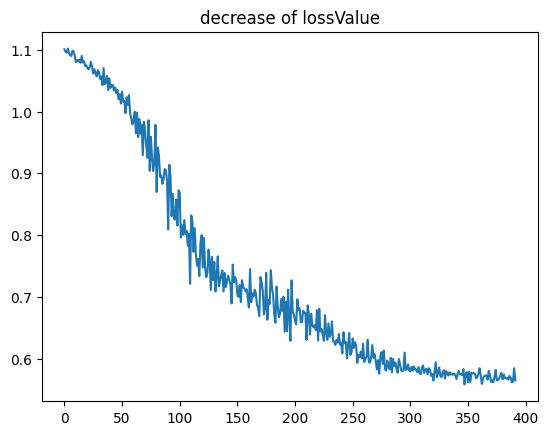

In [21]:
class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(Net, self).__init__(*args, **kwargs)
        self.fc1 = nn.Linear(7, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = x.view(-1, 7)
        # relu 为隐藏层之间的激活函数
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # softmax 为输出层激活函数
        x = torch.softmax(self.fc3(x), dim=1, dtype=torch.float32)
        return x

net = Net()
n_epochs = 100
criterion = nn.CrossEntropyLoss()

# weight_decay 就是l2 正则化
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=0.001)

best_val_loss = float('inf')
early_stopping_patience = 10
lossList = []
num = 0
for epoch in range(n_epochs):
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(torch.float32))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lossList.append(loss.item())

    val_loss = loss.item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counters = 0
    else:
        patience_counters += 1
        if patience_counters > early_stopping_patience:
            print('Early stopping triggered. Training stopped.')
            break

    

print('Finish')
plt.plot(range(len(lossList)), lossList)
plt.title('decrease of lossValue')
plt.show()
        

## 5.模型评估

In [22]:
from sklearn.metrics import classification_report

net.eval()
with torch.no_grad():
    prediction = net(X_test.to(torch.float32))
    predicted_classes = torch.argmax(prediction, dim=1)

print(f'model:\n{classification_report(predicted_classes, y_test)}')


model:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       1.00      1.00      1.00        34
           2       0.94      1.00      0.97        17

    accuracy                           0.99       100
   macro avg       0.98      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

